In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
from tqdm.auto import tqdm

In [3]:
import data
import utils

In [4]:
reader = data.CacuData('data/UCI/archive.ics.uci.edu/ml/machine-learning-databases')

In [5]:
cols = reader.cols
ncols = len(cols)
colcomb = list(itertools.combinations(cols, 2))

In [6]:
!mkdir -p models_clean_group
trainer = utils.Trainer(
    cache_dir='models_clean',
    default_params={
        'objective': 'regression',
        'metric': 'mse',
        'boosting': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'verbose': -1,
        'device': 'cpu',
        'lambda_l2': 0.003,
        'early_stopping_round': 10,
        'num_boost_round': 100,
    },
    nocache_params={
        'num_threads': 20,
    }
)

In [7]:
target = 'ViolentCrimesPerPop'
evaluator = utils.Evaluator(reader, target)

In [8]:
group_mse = {}
for k,g in tqdm(reader.groups.items()):
    trainData = utils.TrainingData(reader, target, columns=g)
    booster = trainer.train_model(trainData)
    new_mse = evaluator.get_model_mse(booster)
    group_mse[k] = new_mse

  0%|          | 0/13 [00:00<?, ?it/s]

In [9]:
groups = list(reader.groups.keys())
group_combs = list(itertools.combinations(groups, 2))
ngroups = len(reader.groups)

In [10]:
group2_mse_e = {}
for k1, k2 in tqdm(group_combs):
    trainData = utils.TrainingData(reader, target, columns=reader.groups[k1] + reader.groups[k2])
    booster = trainer.train_model(trainData)
    new_mse = evaluator.get_model_mse(booster)
    group2_mse_e[(k1, k2)] = new_mse

  0%|          | 0/78 [00:00<?, ?it/s]

In [11]:
group2_mse_er = {}
for k1, k2 in tqdm(group_combs):
    trainData = utils.TrainingData(reader, target, columns=reader.groups[k1] + reader.groups[k2])
    k1size = len(reader.groups[k1])
    k2size = len(reader.groups[k2])
    booster = trainer.train_model(trainData, override_params={
        'interaction_constraints': [list(range(k1size)),list(range(k1size, k1size+k2size))],
    })
    new_mse = evaluator.get_model_mse(booster)
    group2_mse_er[(k1, k2)] = new_mse

  0%|          | 0/78 [00:00<?, ?it/s]

In [12]:
import data
import utils

In [13]:
target = 'ViolentCrimesPerPop'
evaluator = utils.Evaluator(reader, target)

# Group-pair interactions

In [14]:
L_XY = evaluator.base_mse-evaluator.get_feature_matrix(groups, group2_mse_e)
LR_XY = evaluator.base_mse-evaluator.get_feature_matrix(groups, group2_mse_er)

In [15]:
L_X = evaluator.base_mse-evaluator.get_feature_vector(groups, group_mse)

In [16]:
W_XY = (L_XY - L_X.reshape(-1,1) - L_X.reshape(1,-1))*(1-np.eye(L_X.shape[0]))
WR_XY = (LR_XY - L_X.reshape(-1,1) - L_X.reshape(1,-1))*(1-np.eye(L_X.shape[0]))

In [17]:
W_values = W_XY[np.where(~np.eye(L_X.shape[0], dtype=bool))].reshape(-1)/evaluator.base_mse
WR_values = WR_XY[np.where(~np.eye(L_X.shape[0], dtype=bool))].reshape(-1)/evaluator.base_mse

In [18]:
W_values.mean()

-0.17694164649216582

In [19]:
WR_values.mean()

-0.19329227505387564

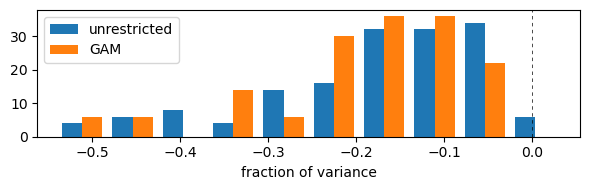

In [20]:
W_hist, bins = np.histogram(np.concatenate([W_values, WR_values]), bins=7)
plt.figure(figsize=(6, 2))
plt.hist([W_values, WR_values], bins=10, label=['unrestricted', 'GAM']);
#plt.title('Distribution of $W$ and $W^r$ values (semantic group pairs)')
plt.xlabel('fraction of variance')
plt.axvline(x = 0, color = 'k',lw=0.5, linestyle=(0,(5,5)))
plt.legend(loc="upper left");
#plt.xlim(-0.6, 0.1)
plt.tight_layout()
plt.savefig('output/group_w_w_dist.pdf')
plt.savefig('output/group_w_w_dist.png')


plt.show()

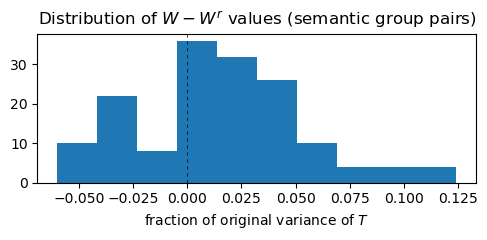

In [21]:
W_hist, bins = np.histogram(np.concatenate([W_values, WR_values]), bins=7)
plt.figure(figsize=(5, 2.5))
plt.hist([W_values-WR_values], bins=10, label=['original', 'restricted']);
plt.title('Distribution of $W-W^r$ values (semantic group pairs)')
plt.xlabel('fraction of original variance of $T$')
plt.axvline(x = 0, color = 'k',lw=0.5, linestyle=(0,(5,5)))
#plt.legend(loc="upper left");
#plt.xlim(-0.6, 0.1)
plt.tight_layout()
plt.savefig('output/group_w_minus_w_dist.pdf')
plt.savefig('output/group_w_minus_w_dist.png')
plt.show()

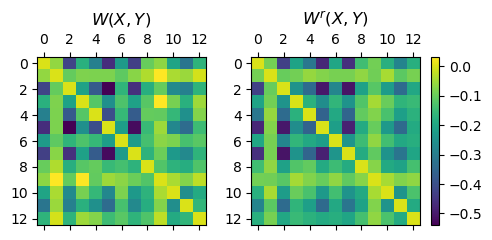

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(5, 2.5))
ax1, ax2 = axes

im1 = ax1.matshow(W_XY/evaluator.base_mse)
ax1.set_title('$W(X,Y)$')
im2 = ax2.matshow(WR_XY/evaluator.base_mse, vmin=W_XY.min()/evaluator.base_mse, vmax=W_XY.max()/evaluator.base_mse)
ax2.set_title('$W^r(X,Y)$')
plt.subplots_adjust(hspace=0, wspace=0, left=0, right=1)
fig.colorbar(im1, ax=ax2);
plt.tight_layout()
plt.savefig('output/group_w_w_heatmap.pdf')
plt.savefig('output/group_w_w_heatmap.png')

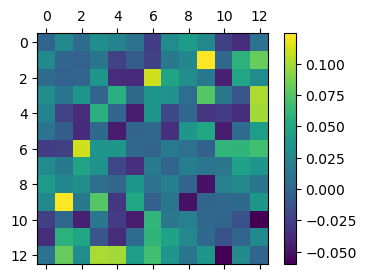

In [23]:
plt.figure(figsize=(4,3))
cax = plt.gca().matshow((W_XY-WR_XY)/evaluator.base_mse)
plt.colorbar(cax);
plt.savefig('output/group_w_w_heatmap.pdf');
plt.savefig('output/group_w_w_heatmap.png');

In [24]:
MSE_diff = (evaluator.get_feature_matrix(groups, group2_mse_er) - evaluator.get_feature_matrix(groups, group2_mse_e))/evaluator.base_mse

In [25]:
MSE_diff.mean()

0.01509288790311674

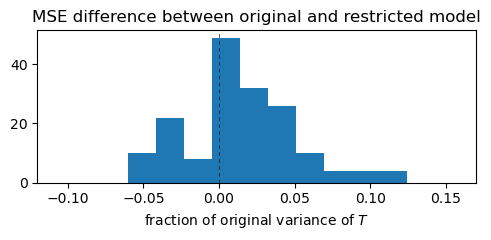

In [26]:
plt.figure(figsize=(5, 2.5))
plt.title('MSE difference between original and restricted model')
plt.hist(MSE_diff.reshape(-1), bins=10);
plt.axvline(x = 0, color = 'k', lw=0.5, linestyle=(0,(5,5)))
plt.xlabel('fraction of original variance of $T$')
plt.tight_layout()
plt.xlim(-0.12, 0.17)
plt.savefig('output/group_mse_diff.pdf')
plt.savefig('output/group_mse_diff.png')

# Groups latex / markdowntable

In [27]:
printable_keys = ["/".join([s.capitalize() for s in k.split("x")]) for k in reader.groups.keys()]

In [28]:
1/len(reader.groups)

0.07692307692307693

In [29]:
for k, pk in zip(reader.groups.keys(), printable_keys):
    print("\midrule")
    print(pk, end="&")
    print(*["\\mbox{%s}"%f for f in reader.groups[k]], sep=", ", end="\\\\\n")

\midrule
Race&\mbox{racepctblack}, \mbox{racePctWhite}, \mbox{racePctAsian}, \mbox{racePctHisp}\\
\midrule
Age&\mbox{agePct12t21}, \mbox{agePct12t29}, \mbox{agePct16t24}, \mbox{agePct65up}\\
\midrule
Income&\mbox{medIncome}, \mbox{pctWWage}, \mbox{pctWFarmSelf}, \mbox{pctWInvInc}, \mbox{pctWSocSec}, \mbox{pctWPubAsst}, \mbox{pctWRetire}, \mbox{medFamInc}, \mbox{perCapInc}, \mbox{NumUnderPov}, \mbox{PctPopUnderPov}\\
\midrule
Race/Income&\mbox{whitePerCap}, \mbox{blackPerCap}, \mbox{indianPerCap}, \mbox{AsianPerCap}, \mbox{OtherPerCap}, \mbox{HispPerCap}\\
\midrule
Education&\mbox{PctLess9thGrade}, \mbox{PctNotHSGrad}, \mbox{PctBSorMore}, \mbox{PctUnemployed}, \mbox{PctEmploy}, \mbox{PctEmplManu}, \mbox{PctEmplProfServ}, \mbox{PctOccupManu}, \mbox{PctOccupMgmtProf}\\
\midrule
Family&\mbox{MalePctDivorce}, \mbox{MalePctNevMarr}, \mbox{FemalePctDiv}, \mbox{TotalPctDiv}, \mbox{PersPerFam}, \mbox{PctFam2Par}, \mbox{PctKids2Par}, \mbox{PctYoungKids2Par}, \mbox{PctTeen2Par}, \mbox{PctWorkMomY

In [32]:
print("|Group name|Features")
print("|---|---|")
for k, pk in zip(reader.groups.keys(), printable_keys):
    print("|", pk, end="|")
    print(*["%s"%f for f in reader.groups[k]], sep=", ", end="|\n")

|Group name|Features
|---|---|
| Race|racepctblack, racePctWhite, racePctAsian, racePctHisp|
| Age|agePct12t21, agePct12t29, agePct16t24, agePct65up|
| Income|medIncome, pctWWage, pctWFarmSelf, pctWInvInc, pctWSocSec, pctWPubAsst, pctWRetire, medFamInc, perCapInc, NumUnderPov, PctPopUnderPov|
| Race/Income|whitePerCap, blackPerCap, indianPerCap, AsianPerCap, OtherPerCap, HispPerCap|
| Education|PctLess9thGrade, PctNotHSGrad, PctBSorMore, PctUnemployed, PctEmploy, PctEmplManu, PctEmplProfServ, PctOccupManu, PctOccupMgmtProf|
| Family|MalePctDivorce, MalePctNevMarr, FemalePctDiv, TotalPctDiv, PersPerFam, PctFam2Par, PctKids2Par, PctYoungKids2Par, PctTeen2Par, PctWorkMomYoungKids, PctWorkMom, NumKidsBornNeverMar, PctKidsBornNeverMar|
| Immigration|PctForeignBorn, NumImmig, PctImmigRecent, PctImmigRec5, PctImmigRec8, PctImmigRec10, PctRecentImmig, PctRecImmig5, PctRecImmig8, PctRecImmig10, PctSpeakEnglOnly, PctNotSpeakEnglWell|
| House|householdsize, PctLargHouseFam, PctLargHouseOccup, Per